# LRS

In [1]:
import os
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

## 1. Ground Sampling Distance (GSD) Calculation:
- Purpose: Converts pixel measurements to real-world distances
- Formula: 
```
meters_per_degree_lat = 111319.9  # Earth's circumference / 360°
meters_per_degree_lon = meters_per_degree_lat * cos(latitude)
gsd_x = pixel_scale_x * meters_per_degree_lon
gsd_y = pixel_scale_y * meters_per_degree_lat
```

## 2. Contour Detection:
- Technique: OpenCV's `findContours` with `cv2.RETR_EXTERNAL` and `cv2.CHAIN_APPROX_SIMPLE`
- Purpose: Identifies continuous road segments in the binary mask
- Filtering: Removes noise by excluding contours with area < 500 pixels

## 3. Principal Component Analysis (PCA) for Road Dimensions:
- Purpose: Estimates road width and length by finding major/minor axes
- Steps:
  a. Center the contour points: `centered = contour - mean`
  b. Calculate covariance matrix: `cov_matrix = np.cov(centered.squeeze().T)`
  c. Find eigenvalues and eigenvectors: `eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)`
  d. Project points onto principal axes:
  ```python
  projected_major = np.dot(centered.squeeze(), major_axis_vector)
  projected_minor = np.dot(centered.squeeze(), minor_axis_vector)
  ```
  e. Calculate dimensions:
  ```python
  length = projected_major.max() - projected_major.min()
  width = projected_minor.max() - projected_minor.min()
  ```

## 4. Coordinate Conversion:
- Pixel to meters conversion:
```python
meters_x = pixels_x * gsd_x
meters_y = pixels_y * gsd_y
area_meters = area_pixels * gsd_x * gsd_y
```

## 5. Statistical Analysis:
- Mean width: `μ = Σ(widths) / n`
- Standard deviation: `σ = √(Σ(x - μ)² / n)`
- Lane estimation: `estimated_lanes = round(mean_width_meters / 3.6)`
  - Uses standard lane width of 3.6 meters
- Total length: Sum of individual segment lengths
- Total area: Sum of individual segment areas

In [2]:
class RoadAnalyzer:
    def __init__(self, tile_image_path, mask_path, main_image_path):
        self.tile_image_path = tile_image_path  # Path to the actual tile image
        self.mask_path = mask_path  # Path to the binary mask
        self.main_image_path = main_image_path  # Path to the main georeferenced image
        self.gsd_x, self.gsd_y = self.extract_gsd_from_main_image()

    def extract_gsd_from_main_image(self):
        """ Extracts Ground Sampling Distance (GSD) from the main georeferenced image metadata. """
        if self.main_image_path is None:
            raise ValueError("Main image path is required for GSD extraction.")

        with Image.open(self.main_image_path) as img:
            metadata = img.tag_v2

            # Extract ModelPixelScaleTag (Tag ID: 33550)
            model_pixel_scale = metadata.get(33550)
            if model_pixel_scale is None:
                raise ValueError("ModelPixelScaleTag not found in the main image metadata.")

            pixel_scale_x, pixel_scale_y = model_pixel_scale[0], model_pixel_scale[1]
            latitude = metadata.get(33922)[4]  # Extract latitude from ModelTiepointTag

            print("Latitude extracted for GSD calculation:", latitude)
            # Convert degrees to meters
            meters_per_degree_lat = 111319.9
            meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(latitude))
            print(f"meters_per_degree_lat: {meters_per_degree_lat}, meters_per_degree_lon: {meters_per_degree_lon}")

            gsd_x = pixel_scale_x * meters_per_degree_lon
            gsd_y = pixel_scale_y * meters_per_degree_lat

            print(f"Ground Sampling Distance (GSD) calculated: gsd_x = {gsd_x}, gsd_y = {gsd_y}")

            return gsd_x, gsd_y

    def pixels_to_meters(self, pixels_x, pixels_y):
        """ Converts pixel dimensions to meters using GSD. """
        meters_x = pixels_x * self.gsd_x
        meters_y = pixels_y * self.gsd_y
        return meters_x, meters_y

    def area_to_meters(self, area_pixels):
        """ Converts area in pixels to square meters. """
        return area_pixels * self.gsd_x * self.gsd_y

    def load_mask(self):
        """ Loads the binary mask image. """
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise ValueError("Could not read mask image")
        return mask

    def extract_contours(self, mask):
        """ Extracts road segments from the mask using OpenCV contours. """
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        road_segments = []
        road_count = 0

        print("Extracting contours...")
        print()
        print("__________________________________________________________________")
        for contour in contours:
            
            road_count = road_count + 1
            print ("ROAD No. " , road_count)
            
            if cv2.contourArea(contour) < 500:  # Ignore small noise
                continue

            # Bounding box and PCA calculation for each contour
            x, y, w, h = cv2.boundingRect(contour)
            print(f"Bounding box for contour: x={x}, y={y}, w={w}, h={h}")

            # PCA for width & length estimation
            mean = np.mean(contour, axis=0)
            centered = contour - mean
            cov_matrix = np.cov(centered.squeeze().T)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

            order = np.argsort(eigenvalues)[::-1]
            major_axis_vector = eigenvectors[:, order[0]]
            minor_axis_vector = eigenvectors[:, order[1]]

            projected_major = np.dot(centered.squeeze(), major_axis_vector)
            projected_minor = np.dot(centered.squeeze(), minor_axis_vector)

            length_pixels = projected_major.max() - projected_major.min()
            width_pixels = projected_minor.max() - projected_minor.min()

            print(f"Length in pixels: {length_pixels}, Width in pixels: {width_pixels}")

            # Convert pixels to meters
            width_meters, length_meters = self.pixels_to_meters(width_pixels, length_pixels)

            segment = {
                'bbox': (x, y, w, h),
                'contour': contour,
                'width_pixels': width_pixels,
                'length_pixels': length_pixels,
                'width_meters': width_meters,
                'length_meters': length_meters,
                'area_pixels': cv2.contourArea(contour),
                'area_meters': self.area_to_meters(cv2.contourArea(contour))
            }
            road_segments.append(segment)

            # Print statistics for the individual segment
            print(f"Road segment {len(road_segments)} statistics:")
            print(f"Width (pixels): {width_pixels}, Length (pixels): {length_pixels}")
            print(f"Width (meters): {width_meters:.2f}, Length (meters): {length_meters:.2f}")
            print(f"Area (meters²): {segment['area_meters']:.2f}")
            print()
            print("__________________________________________________________________")

        print(f"Total road segments extracted: {len(road_segments)}")
        return road_segments


    def calculate_statistics(self, road_segments):
        """ Computes statistics for the detected road segments. """
        widths_pixels = [seg['width_pixels'] for seg in road_segments]
        widths_meters = [seg['width_meters'] for seg in road_segments]
        lengths_meters = [seg['length_meters'] for seg in road_segments]
        areas_meters = [seg['area_meters'] for seg in road_segments]



    def visualize_analysis(self, road_segments):
        """ Overlays detected roads on the tile image instead of the mask. """
        tile_image = cv2.imread(self.tile_image_path)
        result = tile_image.copy()

        for segment in road_segments:
            cv2.drawContours(result, [segment['contour']], -1, (0, 255, 0), 2)

            x, y, w, h = segment['bbox']
            center_x = x + w // 2
            center_y = y + h // 2
            cv2.putText(result, f"{segment['width_meters']:.1f}m",
                        (center_x, center_y),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

        result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 12))
        plt.imshow(result_rgb)
        plt.axis("off")

    def process_mask_image(self):
        """ Main function to process the mask image. """
        mask = self.load_mask()
        road_segments = self.extract_contours(mask)
        self.calculate_statistics(road_segments)
        self.visualize_analysis(road_segments)


In [3]:
TILE_IMAGE_PATH = "../Road_mask/test/tile_30_jpg.rf.fc5c2236fef90b253b903aab6e9ab427.jpg"
MASK_PATH       = "../Road_mask/test/tile_30_jpg.rf.fc5c2236fef90b253b903aab6e9ab427_mask.png"

Latitude extracted for GSD calculation: 27.9125986509454
meters_per_degree_lat: 111319.9, meters_per_degree_lon: 98369.24524576397
Ground Sampling Distance (GSD) calculated: gsd_x = 0.2654109655028968, gsd_y = 0.3003532462290768
Extracting contours...

__________________________________________________________________
ROAD No.  1
Bounding box for contour: x=511, y=563, w=129, h=22
Length in pixels: 128.0, Width in pixels: 21.0
Road segment 1 statistics:
Width (pixels): 21.0, Length (pixels): 128.0
Width (meters): 5.57, Length (meters): 38.45
Area (meters²): 214.28

__________________________________________________________________
ROAD No.  2
Bounding box for contour: x=0, y=443, w=446, h=17
Length in pixels: 445.0, Width in pixels: 16.0
Road segment 2 statistics:
Width (pixels): 16.0, Length (pixels): 445.0
Width (meters): 4.25, Length (meters): 133.66
Area (meters²): 567.59

__________________________________________________________________
ROAD No.  3
Bounding box for contour: x=0, 

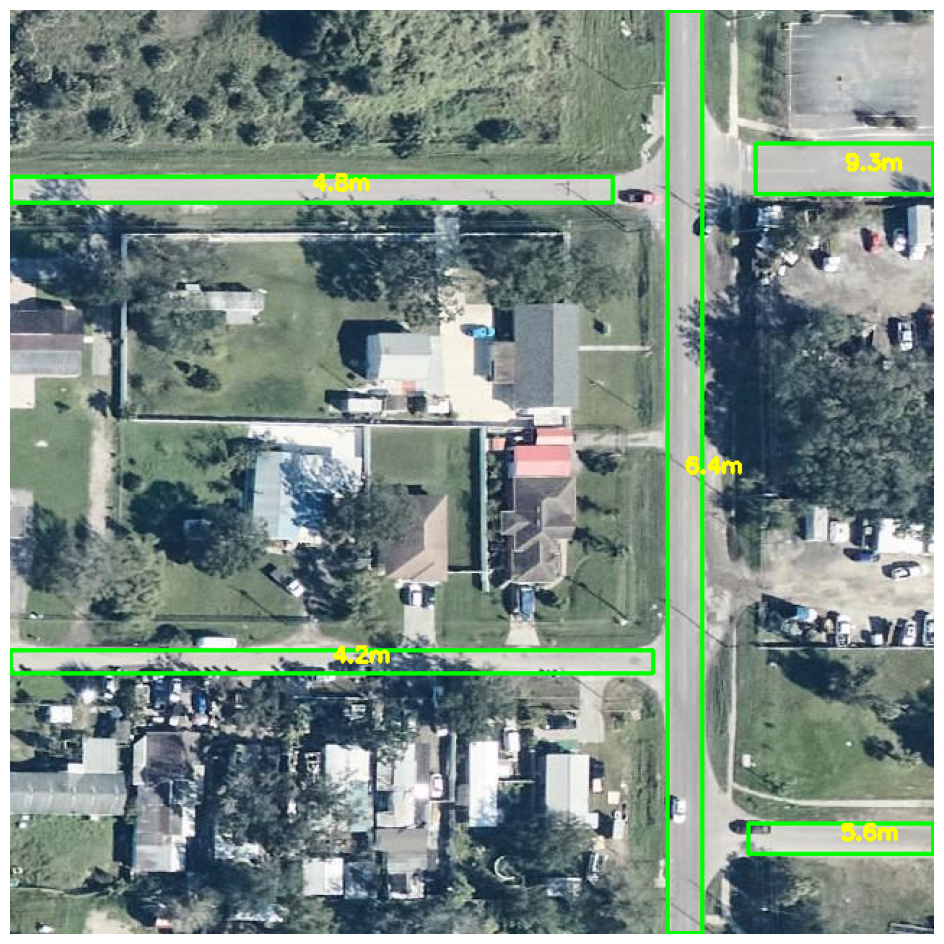

In [4]:
def main():
    # Change the Path According to your dataset
    tile_image_path = TILE_IMAGE_PATH
    mask_path = MASK_PATH
    main_image_path = "../dataset/20241014aC0822230w275445n.tif"

    analyzer = RoadAnalyzer(tile_image_path, mask_path, main_image_path)

    try:
        analyzer.process_mask_image()
        
        plt.show()
    except Exception as e:
        print(f"Error processing mask: {str(e)}")


if __name__ == "__main__":
    main()